In [1]:
import pandas as pd
import simplejson as json

with open('0001_bytearray_master.json') as f:
    byte_array_data = json.load(f)

with open('0002_binary_master.json') as f:
    bin_obj_data = json.load(f)

In [2]:
from collections import defaultdict


def prepare_data(data, name_pattern='', max_threshold=102400, min_threshold=0):
    ret = {'simple': defaultdict(dict), 'partition_aware': defaultdict(dict)}

    for bench in data['benchmarks']:
        params = bench['param'].split('-')
        name = bench['name']
        if name_pattern not in name:
            continue
        
        batch_sz = int(params[2]) if len(params) == 3 else 0
        value_sz = int(params[1])

        if not (min_threshold < value_sz < max_threshold):
            continue
        
        median = bench['stats']['median'] * 1000000
        median = median if batch_sz == 0 else median / batch_sz
        if 'async' in name:
             ret[params[0]][value_sz][f'async-{batch_sz}'] = median
        else:
             ret[params[0]][value_sz][f'sync'] = median
    
    for k in ret.keys():
        for val_sz, timings in ret[k].items():
            new_timings = [timings['sync']]
            for i in [0, 5, 10, 20]:
                new_timings.append(timings[f'async-{i}'])

            ret[k][val_sz] = new_timings
    return ret

In [3]:
def prepare_data_binary(data, name_pattern='', max_threshold=1024 * 1024 * 10, min_threshold=0):
    ret = {'simple': defaultdict(dict), 'partition_aware': defaultdict(dict)}

    for bench in data['benchmarks']:
        params = bench['param'].split('-')
        name = bench['name']
        if name_pattern not in name:
            continue
        batch_sz = int(params[1]) if len(params) == 3 else 0
        value_sz = int(params[2]) if len(params) == 3 else int(params[1])
        if not (min_threshold < value_sz < max_threshold):
            continue
        median = bench['stats']['median'] * 1000000
        median = median if batch_sz == 0 else median / batch_sz
        if 'async' in name:
             ret[params[0]][value_sz][f'async-{batch_sz}'] = median
        else:
             ret[params[0]][value_sz][f'sync'] = median
    
    for k in ret.keys():
        for val_sz, timings in ret[k].items():
            new_timings = [timings['sync']]
            for i in [0, 5, 10, 20]:
                new_timings.append(timings[f'async-{i}'])

            ret[k][val_sz] = new_timings
    return ret

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def plot(data, title='',yscale='linear', time_scale=1, ylabel='us'):
    labels = []
    for k in data['simple'].keys():
        if k // (1024 * 1024) > 0 or k == 1024 * 1024:
            labels.append(f'{k / (1024 * 1024)}Mb')
        elif k // 1024 > 0:
            labels.append(f'{k / 1024}Kb')
        else:
            labels.append(k)

    simple_means, pa_means = {}, {}
    
    for i in range(5):
        simple_means[i] = [v[i] / time_scale for v in data['simple'].values()]
        pa_means[i] = [v[i] / time_scale for v in data['partition_aware'].values()]

    x = np.arange(len(labels))
    width = 0.07

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (15,9)
    plt.yscale(yscale)
    
    batches = [5, 10, 20]
    rects = []
    for i in range(5):
        if i == 0:
            crd = x - width * 4.5, x - width * 3.5
        elif i == 1:
            crd = x - width * 2.5, x - width * 1.5
        elif i == 2:
            crd = x - width * 0.5, x + width * 0.5
        elif i == 3:
            crd = x + width * 1.5, x + width * 2.5
        else:
            crd = x + width * 3.5, x + width * 4.5

        if i == 0:
            lab = 'sync', 'sync-pa'
        elif i == 1:
            lab = 'async', 'async-pa'
        else:
            lab = f'async-{batches[i - 2]}', f'async-pa-{batches[i - 2]}'

        rects.append(ax.bar(crd[0], simple_means[i], width, label=lab[0]))
        rects.append(ax.bar(crd[1], pa_means[i], width, label=lab[1]))

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rect in rects:
        ax.bar_label(rect, padding=3, rotation=75)


    fig.tight_layout()

    plt.show()

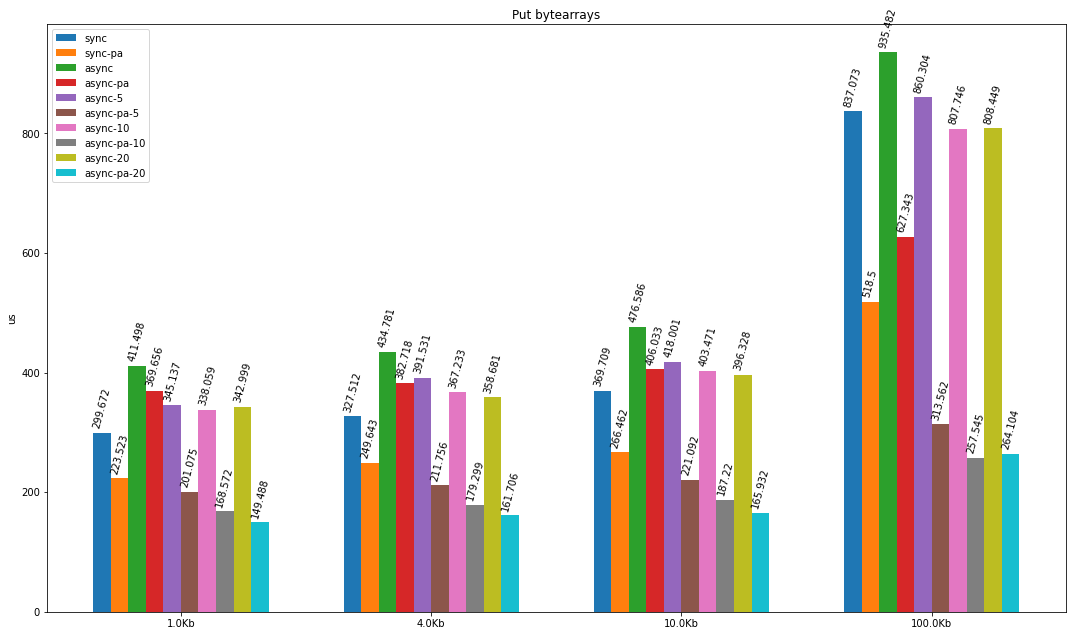

In [13]:
byte_array_put_data = prepare_data(byte_array_data, 'put', max_threshold=128 * 1024)
plot(byte_array_put_data, 'Put bytearrays')

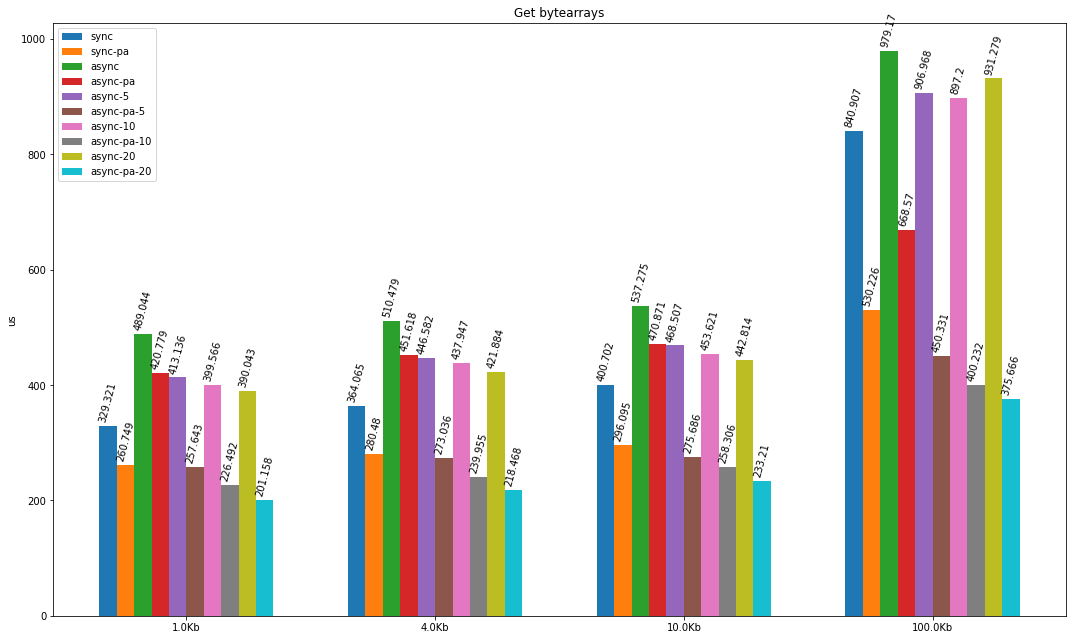

In [6]:
byte_array_get_data = prepare_data(byte_array_data, 'get', max_threshold=128 * 1024)
plot(byte_array_get_data, 'Get bytearrays')

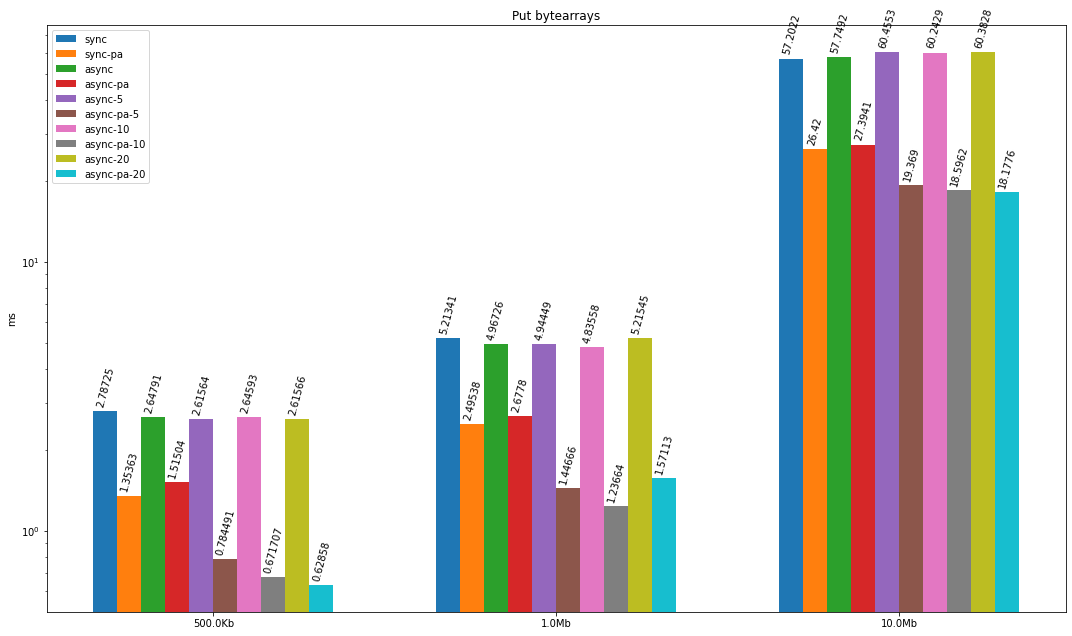

In [7]:
byte_array_put_data_large = prepare_data(byte_array_data, 'put', min_threshold=256 * 1024, max_threshold=20 * 1024 * 1024)
plot(byte_array_put_data_large, 'Put bytearrays', yscale='log', ylabel='ms', time_scale=1000)

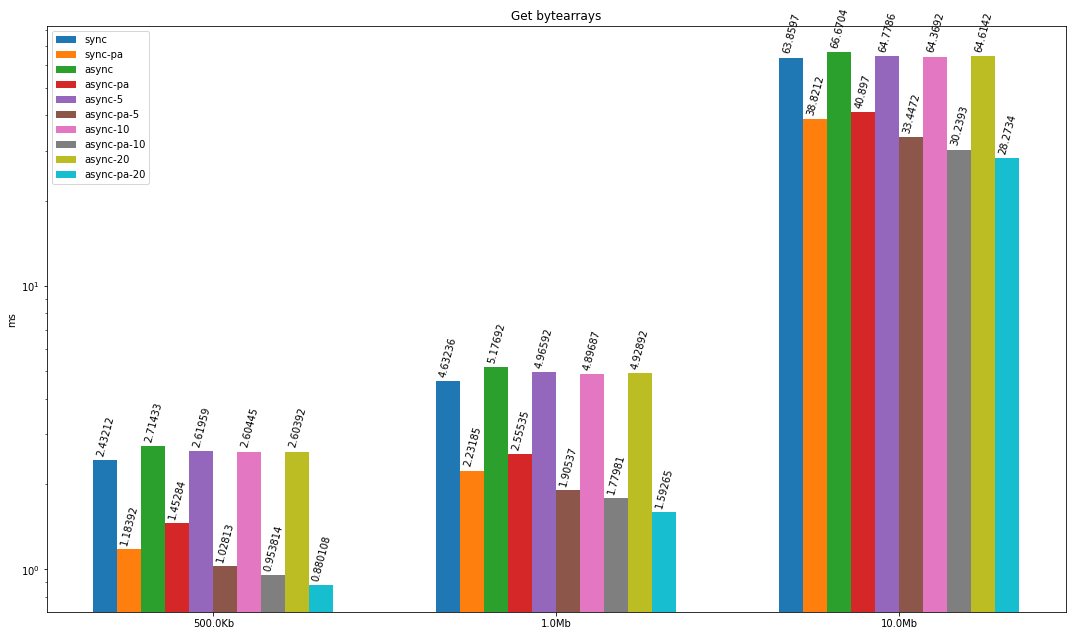

In [8]:
byte_array_get_data_large = prepare_data(byte_array_data, 'get', min_threshold=256 * 1024, max_threshold=20 * 1024 * 1024)
plot(byte_array_get_data_large, 'Get bytearrays', yscale='log', ylabel='ms', time_scale=1000)

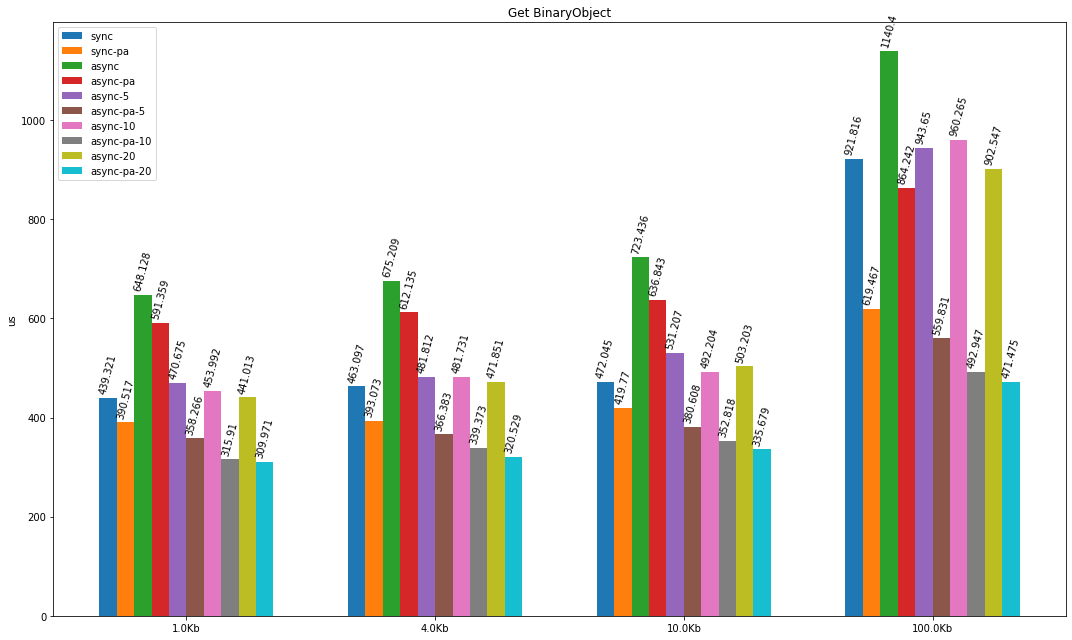

In [9]:
bin_obj_get_data = prepare_data_binary(bin_obj_data, 'get', max_threshold=120 * 1024)
plot(bin_obj_get_data, 'Get BinaryObject')

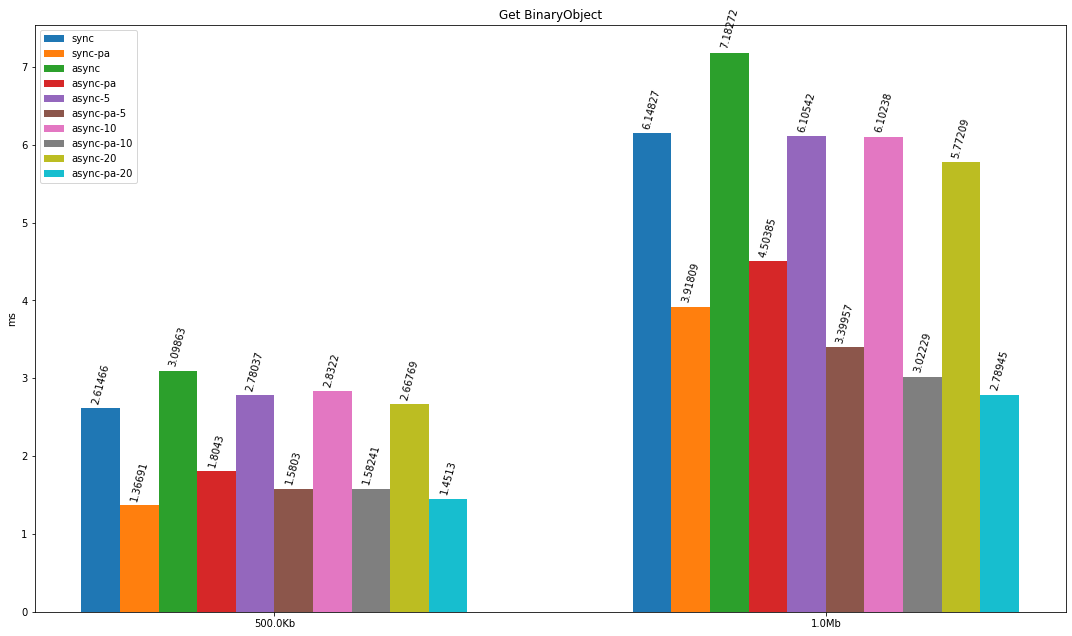

In [10]:
bin_obj_get_data = prepare_data_binary(bin_obj_data, 'get', min_threshold=256 * 1024, max_threshold=2 * 1024* 1024)
plot(bin_obj_get_data, 'Get BinaryObject', ylabel='ms', time_scale=1000)

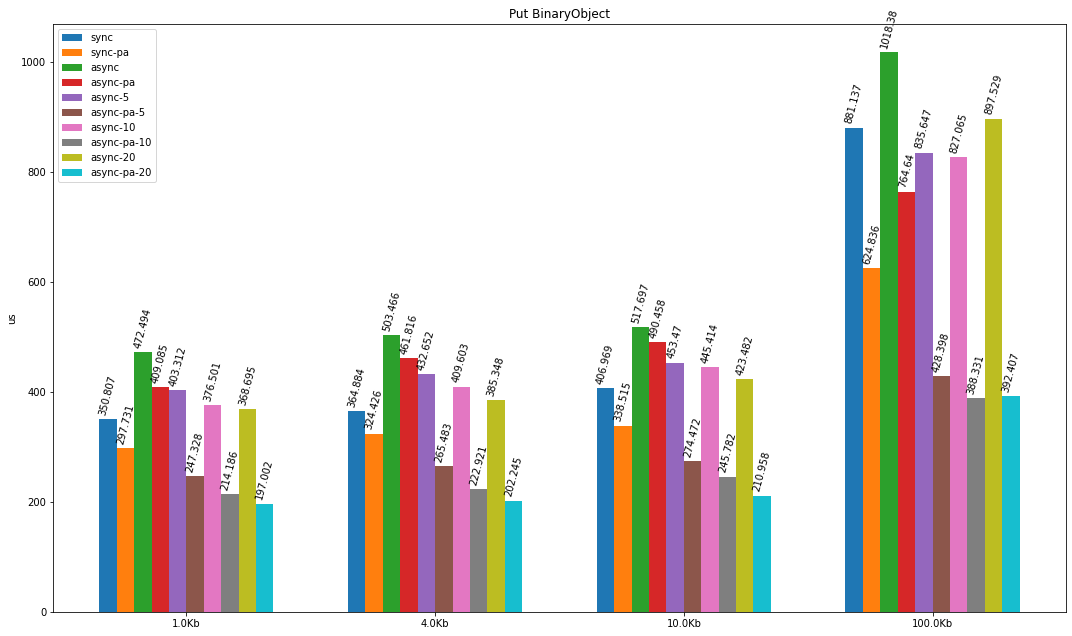

In [11]:
bin_obj_put_data = prepare_data_binary(bin_obj_data, 'put', max_threshold=128 * 1024)
plot(bin_obj_put_data, 'Put BinaryObject')

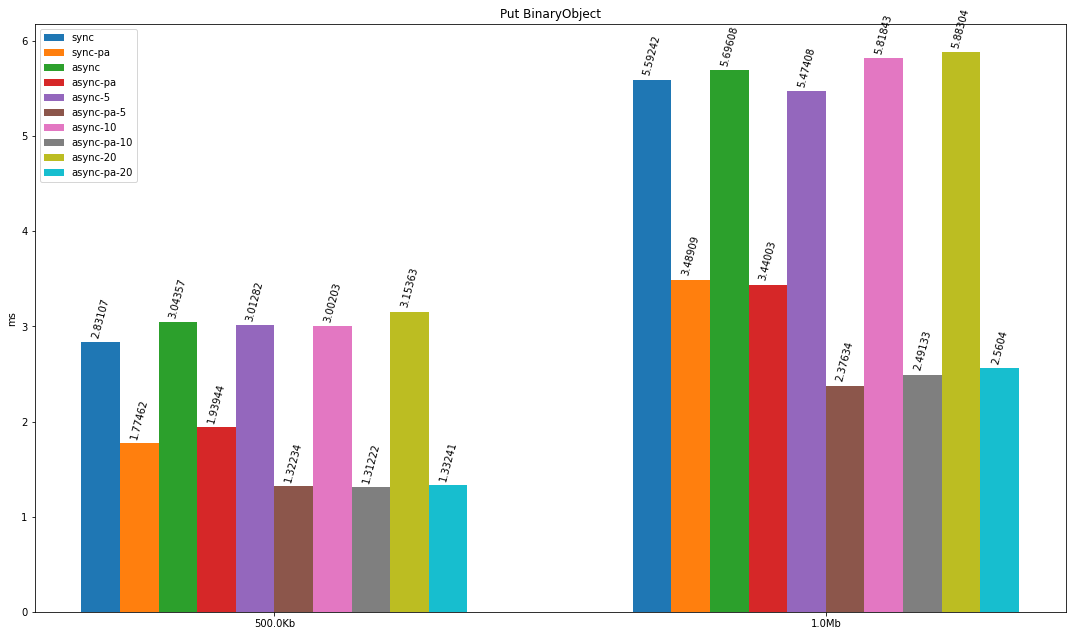

In [12]:
bin_obj_put_data = prepare_data_binary(bin_obj_data, 'put', min_threshold=256 * 1024, max_threshold=2 * 1024* 1024)
plot(bin_obj_put_data, 'Put BinaryObject', ylabel='ms', time_scale=1000)